In [2]:
import numpy as np
import pickle
import os
from matplotlib import pyplot as plt

from vector_CD.cond_ind_tests.parcorr_mult_regularized import ParCorrMult
from tigramite.data_processing import DataFrame

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, MultiTaskLassoCV, ElasticNetCV, LassoLarsIC, MultiTaskElasticNetCV
from sklearn.cross_decomposition import PLSRegression
from statsmodels.stats import multivariate 

# Function Definitions

## Data Generation

In [5]:
def mult_data_conf(samples, dimxy, dimz, coef, z_int=None, n_conf = 'high', random_state = None):
    
    if random_state is None:
        seed = None
        random_state = np.random.default_rng(seed=seed)
    
    data = random_state.standard_normal((samples, 2*dimxy + dimz))
    confounder = random_state.standard_normal((samples, 1))
    
    if z_int: #z_int denotes how dense z is internally connected (None implies unconnected)
        
        if type(z_int) == str:
        
            if z_int == 'high': # z is fully connected 
                data[:,int(2*dimxy):] += confounder

            elif z_int == 'low': # num_int components of z are connected
                num_int = int(dimz/3)    
                data[:,int(2*dimxy):int(2*dimxy)+num_int] += confounder
            
        elif type(z_int) == int: # z_int components of z are connected
            data[:,int(2*dimxy):int(2*dimxy)+z_int] += confounder
        
    if n_conf == 'high':
        n_conf = dimz  # all components of z act as confounders
    elif n_conf == 'low':
        if dimz>2:
            n_conf = int(dimz/3) # n_conf components of z act as confounders
        elif dimz>0:
            n_conf = 1
        else:
            raise ValueError('dim_z should be greater than zero to generate confounder data')
    else:
        raise ValueError('n_conf should be in ["high", "low"]')
    
    data[:,0:dimxy] += data[:,int(2*dimxy):int(2*dimxy+n_conf)].mean(axis=1).reshape(samples, 1) # Z causes X
    data[:,dimxy:int(2*dimxy)] += data[:,int(2*dimxy):int(2*dimxy)+n_conf].mean(axis=1).reshape(samples, 1) # Z causes Y
    data[:,dimxy:int(2*dimxy)] += coef*data[:,0:dimxy] # X causes Y
    
    return data

In [8]:
# Example
dimxy = 1
dimz = 1
samples = 100
coef = 0.2
z_int = None
n_conf = 'high'
data = mult_data_conf(samples, dimxy, dimz, coef, z_int, n_conf)
#data.shape

### Functions for Box-M test

In [10]:
def lin_reg(Z,Y):
    model = LinearRegression().fit(Z,Y)
    pred = model.predict(Z)
    resid = Y-pred
    return resid

def boxm(X,Y,Z,samples):
    ZX = np.hstack((X, Z))
    resid_1 = lin_reg(Z,Y)
    resid_2 = lin_reg(ZX,Y)
    cov_1 = np.cov(resid_1)
    cov_2 = np.cov(resid_2)
    
    cov_list = list([cov_1,cov_2])
    nob_list= list([samples,samples])
    boxm = multivariate.test_cov_oneway(cov_list, nob_list)
    
    return boxm.pvalue

## Rate Computation

In [11]:
def error_rate(error, cmi, realizations, samples, dimxy, dimz, z_int=None, n_conf = None, alpha=0.05):
    
    if error == "type1":
        coef = 0.0
    else:
        coef = 0.2 #0.06
        
    pvals = np.zeros(realizations)
    rate = np.zeros(realizations)
    seed = None
    random_state = np.random.default_rng(seed=seed)
    
    for i in range(realizations):
        
        data = mult_data_conf(samples, dimxy, dimz, coef , z_int, n_conf, random_state)
        
        
        dataframe = DataFrame(data, 
            vector_vars={0:[(i,0) for i in range(dimxy)], 
                         1:[(j,0) for j in range(dimxy, 2*dimxy)], 
                         2:[(k, 0) for k in range(2*dimxy, 2*dimxy+dimz)]}
                              )

        cmi.set_dataframe(dataframe)

        pvals[i] = cmi.run_test(
                X=[(0,0)], 
                Y=[(1,0)], 
                Z = [(2, 0)]
                )[1]
        
        rate[i] = pvals[i] <= alpha
        
    ## Bootstrap-based error
    boot_samples = 1000
    boots = np.zeros((boot_samples))
    for b in range(boot_samples):
        rand = np.random.randint(0, realizations, realizations)
        boots[b] = (pvals[rand] <= alpha).mean()
    rate_error = boots.std()

    print(rate.mean(),rate_error)
    return rate.mean(), rate_error


In [12]:
def metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int=None, n_conf = None):

    metrics_nconf =  {y:{x: dict() for x in corr_type_range} for y in reg_range}
    
    for samples in sample_range:
        for corr_type in corr_type_range:
            
            if corr_type == 'boxm':
                print(samples,'ols',corr_type)
                if error == "type1":
                    coef = 0.0
                else:
                    coef = 0.2
                rate_boxm = np.zeros(realizations)
                pvals_boxm = np.zeros(realizations)
                alpha_box = 0.05
                for r in range(realizations):
                    seed = None
                    random_state = np.random.default_rng(seed=seed)
                    data = mult_data_conf(samples, dimxy, dimz, coef , z_int, n_conf, random_state)
                    X = data[:,0:dimxy]#.reshape(samples,1)
                    Y = data[:,dimxy:int(2*dimxy)]#.reshape(samples,1)
                    Z = data[:,int(2*dimxy):]
                    pvals_boxm[r] = boxm(X,Y,Z,samples)
                    rate_boxm[r] = pvals_boxm[r] <= alpha_box
                    boot_samples = 1000
                    boots = np.zeros((boot_samples))
                    for b in range(boot_samples):
                        rand = np.random.randint(0, realizations, realizations)
                        boots[b] = (pvals_boxm[rand] <= alpha_box).mean()
                    rate_error = boots.std()
                    
                metrics_nconf['ols'][corr_type][samples] = (rate_boxm.mean(), rate_error)
                
                print(rate_boxm.mean(), rate_error)
                print('-----------------------')
                
            else:           
            
                for regr in reg_range:

                    if regr == 'ols':
                        reg = LinearRegression()
                    elif regr == 'ridge':
                        reg = RidgeCV()
                    elif regr == 'pls':
                        reg = PLSRegression(n_components=2)
                    else:
                        raise ValueError("Unknown regression type")

                    if 'max_corr' in corr_type:
                        if 'shuffle' in corr_type:
                            cmi = ParCorrMult(
                                    correlation_type = 'max_corr',
                                    regularization_model = reg,
                                    significance = 'shuffle_test',
                                    sig_blocklength=1,
                                    sig_samples=200)
                        else:
                            cmi = ParCorrMult(
                                    correlation_type = 'max_corr',
                                    regularization_model = reg)

                    elif 'gcm' in corr_type:
                        if 'shuffle' in corr_type:
                            cmi = ParCorrMult(
                                    correlation_type = 'gcm',
                                    regularization_model = reg,
                                    significance = 'shuffle_test',
                                    sig_blocklength=1,
                                    sig_samples=200)
                        elif 'gmb' in corr_type:
                            cmi = ParCorrMult(
                                    correlation_type = 'gcm_gmb',
                                    regularization_model = reg,
                                    significance = 'shuffle_test',
                                    sig_blocklength=1,
                                    sig_samples=200)
                        else:
                            cmi = ParCorrMult(
                                    correlation_type = 'gcm',
                                    regularization_model = reg)


                    elif 'linear_hsic' in corr_type:
                        if 'approx' in corr_type:
                            cmi = ParCorrMult(
                                    correlation_type = 'linear_hsic_approx',
                                    regularization_model = reg,
                                    significance = 'shuffle_test',
                                    sig_blocklength=1,
                                    sig_samples=1000)
                        elif 'kci' in corr_type:
                            cmi = ParCorrMult(
                                    correlation_type = 'linear_hsic_shuffle_kci',
                                    regularization_model = reg,
                                    significance = 'shuffle_test',
                                    sig_blocklength=1,
                                    sig_samples=1000)
                        else:
                            cmi = ParCorrMult(
                                    correlation_type = 'linear_hsic_shuffle',
                                    regularization_model = reg,
                                    significance = 'shuffle_test',
                                    sig_blocklength=1,
                                    sig_samples=200)

                    print(samples,reg,corr_type)
                    metrics_nconf[regr][corr_type][samples] = error_rate(error, cmi, realizations, samples, dimxy, dimz, z_int, n_conf)
                    print('-----------------------')

    return metrics_nconf


## Example

### Error Rate

In [20]:
dimxy = 20
dimz = 20
samples = 100
realizations = 100#500
n_conf = 'low'
z_int = 'high'
correlation_type = 'gcm_gmb' #'linear_hsic_shuffle_kci'

cmi = ParCorrMult(
        correlation_type = correlation_type,
        regularization_model = LinearRegression(),           
        # regularization_model = RidgeCV(),                      
        #regularization_model = MultiTaskLassoCV(),             
        #regularization_model = MultiTaskElasticNetCV(),        
        # regularization_model = PLSRegression(n_components=1), 
        significance = 'shuffle_test',
        sig_blocklength=1,
        sig_samples=1000,
        # verbosity=5,
    )

In [21]:
error = 'power'#'type2'
error_rate(error, cmi, realizations, samples, dimxy, dimz, z_int, n_conf)

0.96 0.018934582118441373


(0.96, 0.018934582118441373)

In [22]:
error = 'type1'
error_rate(error, cmi, realizations, samples, dimxy, dimz, z_int, n_conf)

0.15 0.037555791830288975


(0.15, 0.037555791830288975)

### Metrics for a range of parameters

In [20]:
dimxy = 1
dimz = 1
realizations = 500
sample_range = [100]#, 200, 500]
corr_type_range = ['max_corr']#,'gcm','gcm_gmb','linear_hsic_shuffle_kci']#'linear_hsic_approx' ,'boxm']
reg_range = ['ols']#,'ridge','pls']
z_int = 'high'
n_conf = 'low'

error = 'type1'

In [85]:
metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int, n_conf)

100 LinearRegression() max_corr
0.052 0.010217000538318475
-----------------------


{'ols': {'max_corr': {100: (0.052, 0.010217000538318475)}}}

## Dump and retrieve metrics

In [23]:
# Change Folder Name to the location where the results should be saved 

if os.path.expanduser('~') == '/Users/urmininad':
    folder_name = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/'
else:
    print("Change folder to save Multivariate CI test results as needed")
    newpath_fig = os.getcwd() + '/Mult_CI_Tests/metrics'
    if not os.path.exists(newpath_fig):
      os.makedirs(newpath_fig)
    folder_name = os.getcwd() + '/Mult_CI_Tests/metrics/'

def dump_metrics(conf, results_dict):
    file_name = folder_name+conf
    print("Metrics dump ", file_name.replace("'", "").replace('"', '') + '_metrics.dat')
    file = open(file_name.replace("'", "").replace('"', '') + '_metrics.dat', 'wb')        
    pickle.dump(results_dict, file, protocol=-1)        
    file.close()
    
def get_metrics_from_file(para_setup):

    name_string = '%s-'*len(para_setup)  # % para_setup
    name_string = name_string[:-1]

    try:
        print("load from metrics file  %s_metrics.dat " % (folder_name + name_string % (para_setup)))
        results = pickle.load(open(folder_name + name_string % (para_setup) + '_metrics.dat', 'rb'), encoding='latin1')
    except:
        print('***---*** failed from metrics file '  , (para_setup))
        return None

    return results

def get_results_from_para(para_setup):
    para_setup_str = tuple(para_setup.split("-"))
    results = get_metrics_from_file(para_setup_str)
    return results    

## Plotting function

In [3]:
# Change save_folder to local path as needed
if os.path.expanduser('~') == '/Users/urmininad':
    save_folder = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/local_figures/only_ols_final/'
else:
    print("Change save_folder for figures as needed")
    newpath_fig = os.getcwd() + '/local_figures'
    if not os.path.exists(newpath_fig):
      os.makedirs(newpath_fig)
    save_folder = os.getcwd() + '/local_figures/'

In [24]:
def color_picker(corr_type):
    if 'max_corr' in corr_type:
        return 'red'
    elif 'gcm' in corr_type:
            return'royalblue'
    elif 'hsic' in corr_type:
        return 'mediumseagreen'#'darkslategray'#'darkorange' 
        # elif 'dep' in score_type:
        #     return 'darkred'

# FOR One regression type and different z_int and n_conf
def gen_plots_zint_nconf(para_setup_list, save  = 'no'):
        
    fig, (axs) = plt.subplots(2, 3, figsize=(12,  6))#, layout="constrained")
    axs = axs.ravel()

    for i,para_setup in enumerate(para_setup_list):
                
        para_setup_string = para_setup
        paras = para_setup_string.split('-') #para_setup_string[0].split('-')
        paras = [w.replace("'","") for w in paras]

        dimxy = int(paras[0])
        dimz = int(paras[1])
        err_type = str(paras[2])
        z_int = str(paras[3])
        n_conf = str(paras[4])  
        
        results = get_results_from_para(para_setup)
        

        for reg_type in results.keys():
            
            fig.suptitle((dimxy,dimz, reg_type))       
            axs[i].title.set_text(para_setup)
            
            for corr_type in results[reg_type].keys():
                if corr_type!='boxm':
                                
                    x = list(results[reg_type][corr_type].keys())
                    sample_range_ticks = [str(m) for m in x]
                    y_tot = np.array([results[reg_type][corr_type][sample_size] for sample_size in x])
                    y = y_tot[:,0]
                    std_error = y_tot[:,1]            
                    x = np.arange(0,len(x),1)


                    axs[i].errorbar(x, y, yerr=std_error, label = corr_type, marker = 'o',color = color_picker(corr_type))
                    axs[i].set_xlabel('sample size')
                    if err_type == 'type1':
                        axs[i].set_ylabel(err_type+' error')
                    else:
                        axs[i].set_ylabel('power')
                    axs[i].tick_params(axis='y')
                    axs[i].grid(True)
                    axs[i].set_title(('z_int='+z_int,'n_conf='+n_conf))

                    if err_type == 'type1':
                        axs[i].set_ylim(-0.01, 1.0)
                        axs[i].axhline(y=0.05, color='black', linestyle='dotted')
                    else:
                        axs[i].set_ylim(-0.05, 1.15)
                    

                    axs[i].xaxis.set_ticks(list(x) )
                    axs[i].xaxis.set_ticklabels(sample_range_ticks)

                
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    fig.tight_layout()
    
    # new_name = str(dimxy)+'-'+str(dimz)+'-ols'
    # print(para_setup, '\n-------\n',new_name)
    # print(type(para_setup))
    # print(type(new_name))

    if save == 'yes':
        save_suffix = str(dimxy)+'-'+str(dimz)+'-'+err_type+'-ols-0.06' #para_setup
        save_type = 'pdf'
        # save_folder = os.path.expanduser('~') + '/Documents/Python/Mult_CI_Tests/local_figures/only_ols_final/'
        fig.savefig(save_folder + '%s.%s' %(save_suffix, save_type))

# Experiments for Linear Gaussian Models 

## Example

In [35]:
dimxy = 1
dimz = 20
realizations = 100 #500
sample_range = [100]#, 200, 500]
corr_type_range = ['max_corr','gcm','linear_hsic_shuffle_kci']#'linear_hsic_approx','gcm_gmb' ,'boxm']
reg_range = ['ols']#,'ridge','pls']
z_int = 'high'
n_conf = 'high'
error = 'type1'

para_setup = (dimxy,dimz,error,z_int,n_conf)
conf = '%s-'*len(para_setup) % para_setup
conf = conf[:-1]

In [36]:
metrics_1_20_high_high_type1 = metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int, n_conf)
results_dict = metrics_1_20_high_high_type1
dump_metrics(conf,results_dict)

100 LinearRegression() max_corr
0.02 0.01474730822896165
-----------------------
100 LinearRegression() gcm
0.1 0.02858845746101038
-----------------------
100 LinearRegression() linear_hsic_shuffle_kci
0.11 0.030098702629847686
-----------------------
Metrics dump  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/1-20-type1-high-high_metrics.dat


In [38]:
para_setup = tuple(conf.split("-"))
results = get_metrics_from_file(para_setup)
if results == results_dict:
    print('Metric dump happened correctly')
else:
    print('CHECK!')

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/1-20-type1-high-high_metrics.dat 
Metric dump happened correctly


## Experiments

In [83]:
realizations = 500
sample_range = [100, 200, 300, 500]
corr_type_range = ['max_corr','gcm_gmb','linear_hsic_shuffle_kci']#,'boxm']#'linear_hsic_approx','gcm_gmb' ,'boxm']
reg_range = ['ols']

for dimxy in [5,20]:
    for dimz in [20]:
        for z_int in [None, 'low', 'high']:
            for n_conf in ['low','high']:
                for error in ['type1', 'type2']:
                    para_setup = (dimxy,dimz,error,z_int,n_conf)
                    conf = '%s-'*len(para_setup) % para_setup
                    conf = conf[:-1]
                    
                    # conf = conf+'-0.06'
                    
                    print('====================\n',conf,'\n====================')
                    
                    results_dict = metrics_rate_full(sample_range,corr_type_range,reg_range,error, dimxy, dimz, z_int, n_conf)
                    dump_metrics(conf,results_dict)
                    
                    # para_setup = tuple(conf.split("-"))
                    # results = get_metrics_from_file(para_setup)
                    # if results == results_dict:
                    #     print('Metric dump happened correctly')
                    # else:
                    #     print('CHECK!',conf)
                 
            

 5-20-type1-None-low 
100 LinearRegression() max_corr
0.032 0.0077788626418005356
-----------------------
100 LinearRegression() gcm_gmb
0.088 0.012380740527125187
-----------------------
100 LinearRegression() linear_hsic_shuffle_kci
0.224 0.017966640643147513
-----------------------
200 LinearRegression() max_corr
0.05 0.009949285602494282
-----------------------
200 LinearRegression() gcm_gmb
0.074 0.01147483768948389
-----------------------
200 LinearRegression() linear_hsic_shuffle_kci
0.098 0.013002500682561029
-----------------------
300 LinearRegression() max_corr
0.066 0.011284296344921115
-----------------------
300 LinearRegression() gcm_gmb
0.066 0.011458708478707362
-----------------------
300 LinearRegression() linear_hsic_shuffle_kci
0.06 0.010444538477118077
-----------------------
500 LinearRegression() max_corr
0.048 0.009295331946735414
-----------------------
500 LinearRegression() gcm_gmb
0.06 0.010445325078713444
-----------------------
500 LinearRegression() line

## Plots

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type1-None-low_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type1-low-low_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type1-high-low_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type1-None-high_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type1-low-high_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type1-high-high_metrics.dat 


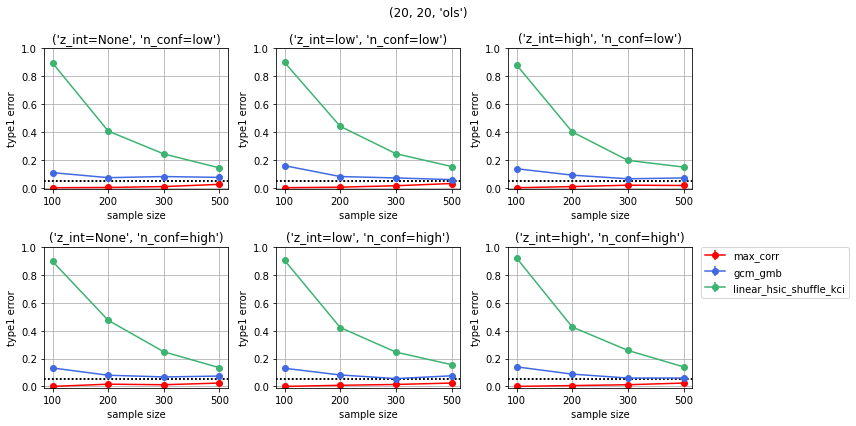

In [118]:
anyconfigurations = [] 
for dimxy in [20]:
    for dimz in [20]:
        for err_type in ['type1']:
            for n_conf in ['low','high']:
                for z_int in [None, 'low', 'high']:

                    para_setup = (dimxy,dimz,err_type,z_int,n_conf)
                    # para_setup = (dimxy,dimz,err_type,z_int,n_conf,0.06)
                    name = '%s-'*len(para_setup) % para_setup
                    name = name[:-1]
                    anyconfigurations += [name]

# anyconfigurations
gen_plots_zint_nconf(anyconfigurations, save = 'no')

load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type2-None-low_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type2-low-low_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type2-high-low_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type2-None-high_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type2-low-high_metrics.dat 
load from metrics file  /Users/urmininad/Documents/Python/Mult_CI_Tests/metrics/only_ols_final/20-20-type2-high-high_metrics.dat 


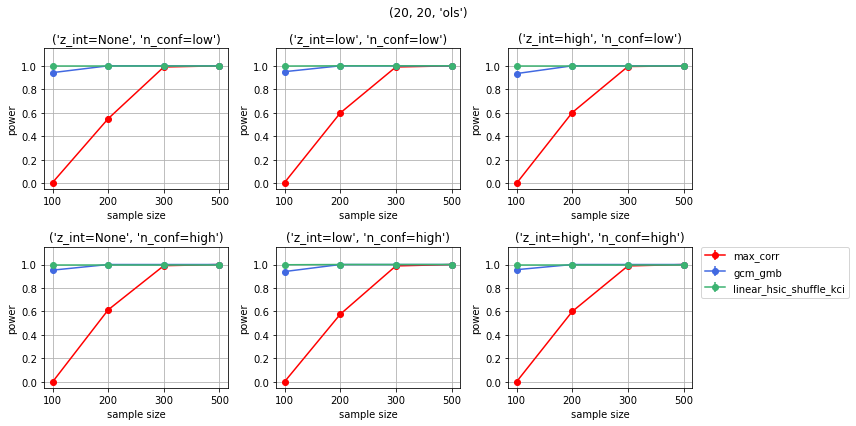

In [115]:
anyconfigurations = [] 
for dimxy in [20]:
    for dimz in [20]:
        for err_type in ['type2']:
            for n_conf in ['low','high']:
                for z_int in [None, 'low', 'high']:

                    para_setup = (dimxy,dimz,err_type,z_int,n_conf)
                    # para_setup = (dimxy,dimz,err_type,z_int,n_conf,0.06)
                    name = '%s-'*len(para_setup) % para_setup
                    name = name[:-1]
                    anyconfigurations += [name]

# anyconfigurations
gen_plots_zint_nconf(anyconfigurations, save = 'no')